## Count terms appearing in tweets

In [1]:
import gzip
import json
import os
import pandas as pd
import re

DATADIR = "../data/all/"

In [2]:
TEXT = "text"
FULLTEXT = "full_text"
EXTENDEDTWEET = "extended_tweet"
RETWEETEDSTATUS = "retweeted_status"

def getTweetText(jsonData):
    text = ""
    if TEXT in jsonData: 
        text = jsonData[TEXT]
    if EXTENDEDTWEET in jsonData and \
       FULLTEXT in jsonData[EXTENDEDTWEET]:
        text = jsonData[EXTENDEDTWEET][FULLTEXT]
    if RETWEETEDSTATUS in jsonData and \
       EXTENDEDTWEET in jsonData[RETWEETEDSTATUS] and \
       FULLTEXT in jsonData[RETWEETEDSTATUS][EXTENDEDTWEET]:
        text = jsonData[RETWEETEDSTATUS][EXTENDEDTWEET][FULLTEXT]
    return(text)

In [3]:
from datetime import datetime, timedelta

DATEFORMAT = "%a %b %d %H:%M:%S %z %Y"
SUMMERTIMEDATE = datetime.strptime("Sun Mar 29 02:00:00 +0000 2020",DATEFORMAT)
WINTERTIMEDATE = datetime.strptime("Sun Oct 25 03:00:00 +0000 2020",DATEFORMAT)

def getTweetDate(jsonData):
    dateString = jsonData["created_at"]
    dateData = datetime.strptime(dateString,DATEFORMAT)+timedelta(hours=1)
    if dateData >= SUMMERTIMEDATE:
        if dateData >= WINTERTIMEDATE: sys.exit("cannot happen")
        dateData += timedelta(hours=1)
    return(dateData.strftime("%Y%m%d"))

In [4]:
DUTCH = "nl"

fileNames = os.listdir(DATADIR)

def saveCounts(counts,outFileName):
    pd.DataFrame.from_dict(counts,orient="index").to_csv(outFileName,header=False)

def readCounts(inFileName):
    countsDf = pd.read_csv(inFileName,header=None,index_col=0)
    return(countsDf.to_dict()[1])

def search(query):
    counts = {}
    for inFileName in fileNames:
        if re.search(r"2*z",inFileName):
            inFile = gzip.open(DATADIR+inFileName,mode="rt")
            for line in inFile:
                jsonData = json.loads(line)
                tweetText = getTweetText(jsonData)
                tweetDate = getTweetDate(jsonData)
                tweetLang = jsonData["lang"]
                if tweetLang == DUTCH and re.search(query,tweetText,flags=re.IGNORECASE):
                    if tweetDate in counts: counts[tweetDate] += 1
                    else: counts[tweetDate] = 1
            inFile.close()
    counts = {k:v for k, v in sorted(counts.items(), key=lambda item: item[0])}
    return(counts)

In [5]:
#rivm = search("rivm")
#saveCounts(rivm,"rivm.csv")
#orona = search("corona")
#saveCounts(corona,"corona.csv")
#covid = search("covid")
#saveCounts(covid,"covid.csv")
#mondkapje = search("mondkapje")
#saveCounts(mondkapje,"mondkapje.csv")

rivm = readCounts("rivm.csv")
corona = readCounts("corona.csv")
covid = readCounts("covid.csv")
mondkapje = readCounts("mondkapje.csv")

### Plot absolute values

<IPython.core.display.Javascript object>


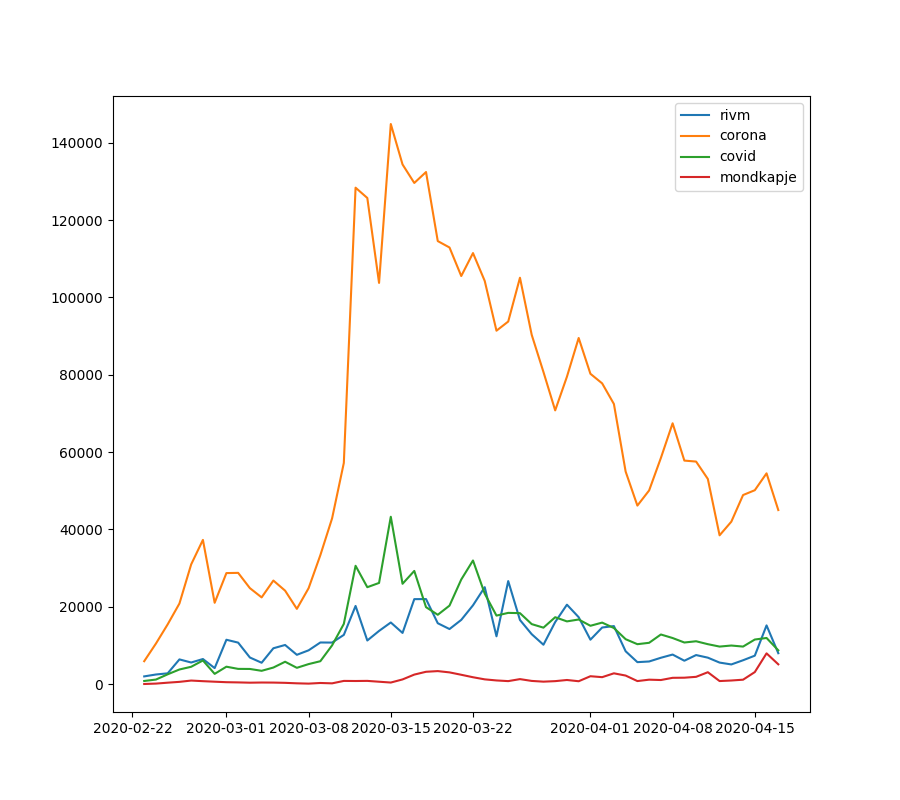

In [9]:
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

DATEFORMAT = "%Y%m%d"

def getWeekendDates(dateStrings):
    weekendDates = []
    for ds in dateStrings:
        d = datetime.strptime(str(ds),DATEFORMAT)
        if d == 0 or d == 6: weekendDates.append(d)
            
def stringArrayToDates(stringList,dateFormat=DATEFORMAT):
    return([datetime.strptime(str(date),dateFormat) for date in stringList])

weakendDates = getWeekendDates(rivm.keys())
plt.figure(figsize=(9,8))
ax1 = plt.subplot(111)
ax1.plot_date(stringArrayToDates(rivm.keys()),list(rivm.values()),xdate=True,fmt="-",label="rivm")
ax1.plot_date(stringArrayToDates(corona.keys()),list(corona.values()),xdate=True,fmt="-",label="corona")
ax1.plot_date(stringArrayToDates(covid.keys()),list(covid.values()),xdate=True,fmt="-",label="covid")
ax1.plot_date(stringArrayToDates(mondkapje.keys()),list(mondkapje.values()),xdate=True,fmt="-",label="mondkapje")
dummy = ax1.legend()
plt.show()

### Plot normalized values

In [64]:
import pandas as pd

def normalize(dateCounts,countsIn):
    countsOut = {}
    for key in countsIn:
        if int(key) in dateCounts.index: 
            countsOut[key] = countsIn[key]/dateCounts.loc[int(key)]["count"]
    return(countsOut)

dateCounts = pd.read_csv(DATADIR+"../date-counts.csv",index_col=["date"])

In [65]:
rivmNorm = normalize(dateCounts,rivm)
coronaNorm = normalize(dateCounts,corona)
covidNorm = normalize(dateCounts,covid)
mondkapjeNorm = normalize(dateCounts,mondkapje)

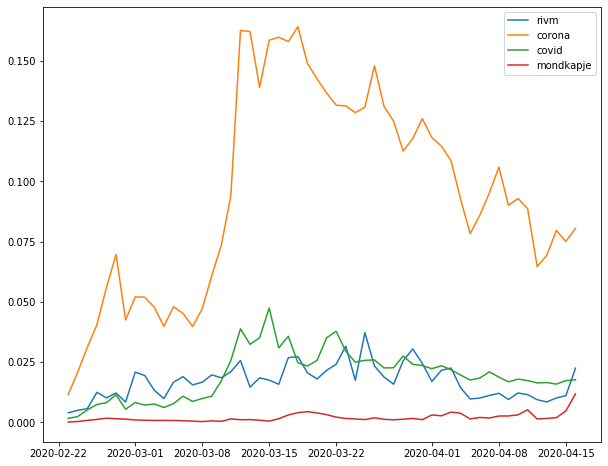

In [66]:
plt.figure(figsize=(10,8))
ax2 = plt.subplot(111)
ax2.plot_date(stringArrayToDates(rivmNorm.keys()),list(rivmNorm.values()),xdate=True,fmt="-",label="rivm")
ax2.plot_date(stringArrayToDates(coronaNorm.keys()),list(coronaNorm.values()),xdate=True,fmt="-",label="corona")
ax2.plot_date(stringArrayToDates(covidNorm.keys()),list(covidNorm.values()),xdate=True,fmt="-",label="covid")
ax2.plot_date(stringArrayToDates(mondkapjeNorm.keys()),list(mondkapjeNorm.values()),xdate=True,fmt="-",label="mondkapje")
dummy = ax2.legend()

## Content analysis

In [10]:
import gzip
import json
import os
import pandas as pd
import re

DATADIR = "../data/all/"
ID = "id_str"
LANG = "lang"
USER = "user"
SCREENNAME = "screen_name"
RIVM = "rivm"
DUTCH = "nl"
TARGETDATES = ["20200412","20200413","20200414","20200415","20200416","20200417","20200418"]
QUERY = "mondkapje"

def removeNewlines(text):
    return(re.sub(r"\n"," ",text))

fileNames = os.listdir(DATADIR)
texts = {}
dates = {}
for inFileName in fileNames:
    inFileDate = inFileName[0:8]
    if inFileDate in TARGETDATES:
        inFile = gzip.open(DATADIR+inFileName,mode="rt")
        for line in inFile:
            jsonData = json.loads(line)
            tweetText = removeNewlines(getTweetText(jsonData))
            tweetLang = jsonData[LANG]
            tweetId = jsonData[ID]
            tweetUser = jsonData[USER][SCREENNAME]
            if tweetLang == DUTCH and \
               re.search(QUERY,tweetText,flags=re.IGNORECASE) and \
               re.search(RIVM,tweetText,flags=re.IGNORECASE):
                texts[tweetId] = {"user":tweetUser,"text":tweetText}
                dates[tweetId] = int(inFileDate)
        inFile.close()
len(texts)

6912

In [11]:
pd.DataFrame.from_dict(texts,orient="index").to_csv("mondkapje-tweets.csv",header=False)

In [49]:
ANNOTATIONFILE = "human-labels.txt"

inFile = open(ANNOTATIONFILE,"r")
annotations = {}
minutes = {}
for line in inFile:
    (userName,date,tweetId,nbr,label) = line.strip().split()
    annotations[tweetId] = label
    minutes[date[0:12]] = True
inFile.close()

print("annotation time: {0:d} minutes ({1:0.1f} tweets per minute)".\
      format(len(minutes),round(len(annotations)/len(minutes),1)))

annotation time: 164 minutes (11.8 tweets per minute)


In [42]:
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"
NEGATIVE = "NEGATIVE"
POSITIVE = "POSITIVE"

labelsPerDate = {}
for tweetId in dates:
    if tweetId in annotations and annotations[tweetId] != IRRELEVANT:
        date = int(dates[tweetId])
        label = annotations[tweetId]
        if not date in labelsPerDate: labelsPerDate[date] = {}
        if not label in labelsPerDate[date]: labelsPerDate[date][label] = 0
        labelsPerDate[date][label] += 1
labelsPerDate

{20200417: {'NEGATIVE': 77, 'POSITIVE': 3, 'NEUTRAL': 3},
 20200415: {'NEGATIVE': 135, 'NEUTRAL': 8, 'POSITIVE': 6},
 20200412: {'NEUTRAL': 1, 'NEGATIVE': 8},
 20200416: {'NEGATIVE': 637, 'NEUTRAL': 58, 'POSITIVE': 24},
 20200413: {'NEGATIVE': 36, 'POSITIVE': 2},
 20200414: {'NEGATIVE': 76}}

<IPython.core.display.Javascript object>


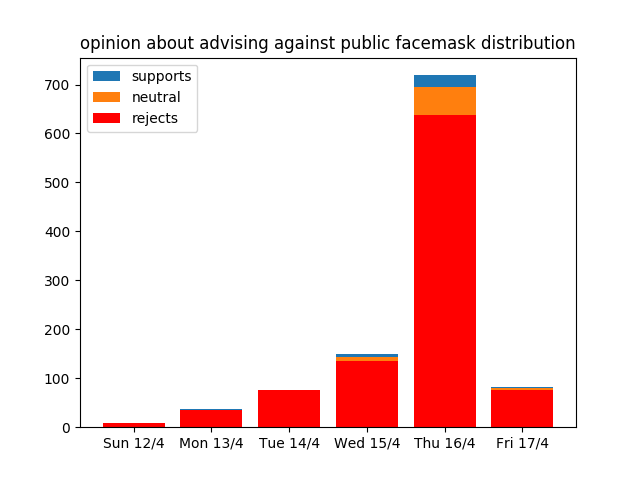

In [43]:
import matplotlib.pyplot as plt

labels = {"NEGATIVE":"rejects","POSITIVE":"supports","NEUTRAL":"neutral"}

for date in labelsPerDate:
    for label in [NEGATIVE,NEUTRAL,POSITIVE]:
        if not label in labelsPerDate[date]:
            labelsPerDate[date][label] = 0

negative = [labelsPerDate[date][NEGATIVE] for date in labelsPerDate.keys()]
neutral = [labelsPerDate[date][NEUTRAL] for date in labelsPerDate.keys()]
positive = [labelsPerDate[date][POSITIVE] for date in labelsPerDate.keys()]
negplusneu = [negative[i]+neutral[i] for i in range(0,len(neutral))]
plt.bar(list(labelsPerDate.keys()),positive,label=labels[POSITIVE],bottom=negplusneu)
plt.bar(list(labelsPerDate.keys()),neutral,label=labels[NEUTRAL],bottom=negative)
plt.bar(list(labelsPerDate.keys()),negative,label=labels[NEGATIVE],color="r")
plt.title("opinion about advising against public facemask distribution")
plt.xticks(list(labelsPerDate.keys()),["Fri 17/4","Wed 15/4","Sun 12/4","Thu 16/4","Mon 13/4","Tue 14/4"])
plt.legend()
plt.show()